# 1. Introduction
The purpose of this notebook is to assess the profit opportunity of quantile trading strategy based on factors prediction.

Though traditional financial ratios offer valuable insights into a company's financial health, they may not always provide the most timely or comprehensive perspective for quantile trading. A factor-based approach, with its focus on predictive analytics and a broader set of variables, can offer a more dynamic and potentially more profitable strategy for navigating the complexities of the US equity market. Therefore, in this notebook, we will try to construct a dynamic quantile trading strategy based on factor and equity return prediction.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.metrics import r2_score
from seaborn import heatmap
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

from src import *

# 2. Data

We mainly obtain price and financial data from Quandl database (EOD and Zacks). The preprocess of data contains 3 major parts:
1. Universe selection
2. Ratio calculation
3. Return calculation

We then perform exploratory data analysis (EDA) on ratios and factor returns to guide our prediction model construction.

In [27]:
tickers = find_valid_universe()
print(f"Our universe contains {len(tickers)} tickers in total.")

Our universe contains 396 tickers in total.


In [28]:
ratio = calc_ratio(use_cache=True, use_data_cache=True, tickers=tickers
                   ).dropna(how="all", axis=1)
ratio_col = list(set(ratio_col).intersection(ratio.columns))
ratio.shape

(98575, 69)

In [29]:
print(f"Ratio list (n={len(ratio_col)}): {ratio_col}")

Ratio list (n=68): ['excl_exp', 'curr_ratio', 'cash_profit', 'oper_cash_flow_per_share', 'ret_invst', 'V20', 'ebit_margin', 'rev_growth', 'AU', 'ret_6_12', 'VEMA12', 'price_pos', 'AD', 'quantile_95', 'PVO', 'cmo', 'rs_volatility', 'p_volatility', 'Altman_Z_Score', 'DPO', 'rcv_turn', 'win_pct', 'alpha6', 'pretax_profit_margin', 'book_val_per_share', 'asset_turn', 'z_score', 'AR', 'BIASVOL', 'bias', 'day_sale_rcv', 'FI', 'free_cash_flow_per_share', 'skew', 'TURN10', 'ret_1_6', 'volume_shock', 'yz_volatility', 'rd_bias', 'macd', 'tot_debt_tot_equity', 'ret_0_1', 'ret_autocorr', 'free_cash_flow', 'kurt_skew', 'NPR', 'profit_margin', 'pe', 'illiquidity', 'HMA', 'ret_asset', 'gross_margin', 'fluc', 'invty_turn', 'ulcer', 'VSTD20', 'RPPS', 'BR', 'ret_equity', 'K20', 'ERBU', 'lterm_debt_cap', 'ERBE', 'asset_growth', 'DC', 'ret_tang_equity', 'oper_profit_margin', 'alpha12']


In [30]:
factor = calc_factor(use_cache=False, ratio=ratio)
factor.shape

(290, 68)

In [3]:
df_ff = get_ff_data()
df_ff.shape
price = pd.read_pickle("data/price.pkl")["adj_close"].unstack("ticker")

price = fill_price_dates(price, droplevel=False).ffill()
price.shape

(8822, 392)

# 3. Factor Selection

In [4]:
ratio = pd.read_pickle('data/ratio.pkl')
factor = pd.read_pickle('data/factor.pkl').shift(1)

In [5]:
def predict_factor_ret(factor,method):
    if method == 'time_weight':
        predicted_factor_ret = time_weight_prediction(factor)
    elif method == 'arima':
        predicted_factor_ret = arima_prediction(factor)
    elif method == 'var':
        predicted_factor_ret = var_prediction(factor)
        
    return predicted_factor_ret


################ three method #####################

def time_weight_prediction(factor):
    n = 12

    def weighted_average(window):
        if len(window) < n - 1:
            return np.nan
        weights = np.arange(1, n) / np.arange(1, n).sum()
        return (window.iloc[-n + 1:] * weights).sum() / weights.sum()

    predicted_factor_ret = factor.shift(1).rolling(window=n, min_periods=n-1).apply(weighted_average)
    return predicted_factor_ret

def arima_prediction(factor):
    
    def arima(df):
        window_size = 12
        rolling_predictions = []

#         model = auto_arima(factor.iloc[:,0].dropna(),start_p=0, start_q=0,
#                    max_p=5, max_q=5, m=1,
#                    start_P=0, seasonal=False,
#                    d=None, D=0, trace=True,
#                    error_action='ignore',  
#                    suppress_warnings=True, 
#                    stepwise=True)
        
        for end in range(window_size, len(df)):
            train_data = df[:end]
            model = ARIMA(train_data, order=(1,0,0)) 
            model_fit = model.fit()
            pred = model_fit.forecast()
            rolling_predictions.append(pred[0])

        return pd.Series([np.nan] * window_size + rolling_predictions,index = df.index)
    
    predicted_factor_ret = factor.apply(arima)
    return predicted_factor_ret

def var_prediction(factor):
    
    window_size = 12
    rolling_predictions = []
    predicted_factor_ret = factor.copy()
    df = factor.copy().fillna(0)

    for end in range(window_size, len(df)):
        train_data = df.iloc[:end]
        model = VAR(train_data)
        model_fit = model.fit(maxlags=1) 
        pred = model_fit.forecast(train_data.values[-model_fit.k_ar:], steps=1)
        rolling_predictions.append(pred[0])

    for i, col in enumerate(df.columns):
        predicted_factor_ret[col] = [np.nan] * window_size + [pred[i] for pred in rolling_predictions]
    
    return predicted_factor_ret

In [6]:
# method_lst = ['time_weight','arima','var']
# predicted_factor_ret = predict_factor_ret(factor,'time_weight')

In [7]:
def choose_factor(predicted_factor_ret):
    r1 = predicted_factor_ret.T.copy()
    for i in r1.columns:
        r1[i] = r1[i].rank()

    r = r1.copy().dropna(how="all",axis=1)

    factor_chosen = {}
    for date in r.loc[:, "2007-05-31":].columns:
        factor_chosen[date] = r[date].nlargest(10).index.tolist()
        
    return factor_chosen

In [8]:
predicted_factor_ret = pd.read_pickle('predicted_factor_arima.pkl')
factor_chosen = choose_factor(predicted_factor_ret)

# 4. Trade

## 4.1. Single-Stock Ranking

In [15]:
from sklearn.preprocessing import scale

def single_stock_pred_ols(
        ratio: pd.DataFrame, 
        factor_chosen: dict[datetime, list[str]],
        min_ticker: int = 50,
) -> pd.DataFrame:
    """
    Prediction next period single stock return
    
    Parameters
    ----------
    ratio: pd.DataFrame
        Index: (date, ticker)
        column: ratios + forward return
    factor_chosen: dict[datetime, list[str]]
        date -> list of factor selected for the period
    min_ticker: int
        minimum number of ticker predicted to generate prediction,
        If too many ticker has missing on any of the selected factor 
        on certain date, we will not predict, i.e. change position on this date.
        
    Returns
    -------
    pd.DataFrame:
        Index: (date, ticker)
        Columns: "predicted_ret"
    """
    pred = {}
    for train_date, selected in factor_chosen.items():

        # Make sure both train / test date has ratio
        test_date = train_date + pd.offsets.MonthEnd(1)
        if any([x not in ratio.index.get_level_values("date").unique() 
                for x in [train_date, test_date]]):
            print(f"Not trained on {train_date}: No ratio data on train/test date")
            continue
            
        # Filter training dataset (drop NaN)
        train_df = ratio.loc[train_date][
            list(set(selected + ["ret_0_1"]))].dropna(how="any")
        if len(train_df) < min_ticker:
            print(f"Not trained on {train_date}: Too many tickers have missing")
            continue
        
        # Training with current month selected factor + return
        X_train = scale(train_df[selected])
        y_train = train_df["ret_0_1"]
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predicting next month
        test_df = ratio.loc[test_date][selected].dropna(how="any")
        pred[test_date] = pd.Series(
            model.predict(scale(test_df)),
            index = test_df.index
        )
    return pd.DataFrame(pred).unstack().dropna().rename("predicted_ret").to_frame()

## 4.2. Backtest

In [16]:
def backtest_pipe(
    name,
    factor_chosen,
    ratio = ratio,
    pred_func = single_stock_pred_ols, 
) -> pd.Series:
    """
    Combine single stock prediction, backtest position calculation, and 
    backtest PnL tracking in the same function for easy use.
    
    Parameters
    ----------
    name: str
        Describe how factor are selected
    factor_chosen: dict[datetime, list[str]]
        a dictionary of factor selected
    ratio: pd.DataFrame
        Index: (date, ticker)
        column: ratios + forward return
    pred_func: Callable
        single stock prediction function, default = OLS.

    Returns
    -------
    pd.Series: 
        backtest cumulative return results evaluation, e.g. sharpe...
        
    This function also draw plot of cumulative with given name.
    """
    # Equity return prediction
    predicted_returns = pred_func(
        ratio=ratio, factor_chosen=factor_chosen)
    
    # Trading backtest
    INIT_CAPITAL = 2e7
    position = calc_position_by_rank(
        df_price=price, 
        df_ratio=predicted_returns.unstack("ticker"),
        rank_formula="predicted_ret",
        lb=0,
        ub=0.1,
        interval=None,
        use_change=False,
        position_size=INIT_CAPITAL / 20
    )
    trade_cls = CalcTrade(
        df_price=price,
        init_cap=INIT_CAPITAL
    )
    summary_df = trade_cls.iter_dates(position=position)
    summary_df["total_ret"].rename(name).plot(figsize=(12,4), title="Entire Period Return")

    return pd.Series({
        **eval_return(summary_df["total_ret"], df_ff=df_ff, ann_factor=12),
        **ff_decomposition(summary_df["total_ret"], df_ff=df_ff, ann_factor=12)
    }, name=name)

Not trained on 2024-02-29 00:00:00: No ratio data on train/test date
Not trained on 2024-02-29 00:00:00: No ratio data on train/test date
Not trained on 2024-02-29 00:00:00: No ratio data on train/test date


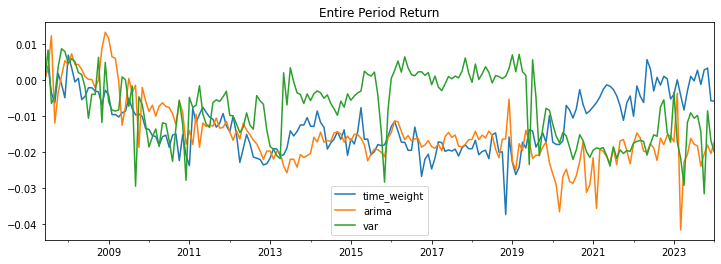

In [17]:
results = {}
for name in ['time_weight','arima','var']:
    predicted_factor_ret = pd.read_pickle('predicted_factor_%s.pkl'%name)
    factor_chosen = choose_factor(predicted_factor_ret)
    results[name] = backtest_pipe(name, factor_chosen)
    plt.legend()

In [16]:
pd.DataFrame(results)

,time_weight,arima,var
return,-0.045615,-0.020408,-0.042715
mean,-0.000070,0.000252,0.000106
std,0.004886,0.004923,0.007400
skew,-0.275212,0.895137,-0.040886
kurtosis,1.596767,3.664411,8.603995
sharpe,-0.291763,-0.062604,-0.109157
sharpe_mkt,-0.011343,0.000653,-0.004760
sortino,-0.383667,-0.100353,-0.134596
var,-0.031671,-0.024052,-0.026644
cvar,-0.042255,-0.033631,-0.064505
